# EUI Tutorial ISRO-ESA Workshop January, 2026 India


# The EUI data analysis tutorial
Welcome to the Extreme Ultraviolet Imager (EUI) data analysis tutorial. In this Jupyter notebooks, we are going to have some fun with EUI data coming from it's three telescopes: 
- Full Sun Imager (FSI). 
  - This telescope has a field of view of 3.8 degrees, which means it can always capture the full solar disc, even when it's close to the Sun. It has a filter wheel that allows it to look at the Sun in either 17.4 or 30.4 nm. The filter wheel can also be used to block all the light getting to the detector. 
- High Resolution Imager Extreme UltraViolet (HRIEUV). 
  - This telescope has a field of view of approximately 0.28 degrees, and shows the Sun in high resolution 17.4 nm. It has a filter wheel that has two additional 17.4 nm filters, as well as an open position (no filter) and a blocking position. Nominally, the filter wheel is in the 17.4 nm position to reduce the amount of light hitting the detector in between the exposures. The open position is used only when very high cadence is needed or when we are imaging quiet Sun areas.
- High Resolution Imager Lyman Alpha (HRILYA)
  - This telescope has a field of view of approximately 0.28 degrees, and shows the Sun in high resolution in 121.6 nm. In front of the detector is an image intensifier.

## Python packages and data
This tutorial can be run in a Jupyter Notebook. They were tested in an up-to-date miniconda environment.

- create conda environment "conda create -n nameofyourchoice"
- conda activate nameofenv
- conda install ipython jupyterlab matplotlib sunpy sunpy-soar astropy pandas scipy ipympl scikit-image
- To start Jupyter Server on your local machine, type "jupyter lab", which will open a browser you can use to open a Jupyter Notebook file.

## Data

It is possible to retrieve released EUI data directly through the web during workshop, and throughout this tutorial there will be a few instances where we will use Fido (part of SunPy) to search and retrieve EUI files based on their descriptor. 
To avoid large downloads duirng the wprkshop, the required data is also provided along with this notebook. Download the files and keep them in the same location as this ipynb file.

We will be playing with EUI data that is part of [release 6.0](https://www.sidc.be/EUI/data/latest_release_notes.html).

## Levels
Every release consists of level 1, 2 and 3 files. The L1 files are uncalibrated image files, but with housekeeping meta-data added. The L2 files contain calibrated image data, created with our euiprep software. The calibration process consists of  dark/flat correction, correcting for geometric distortions, normalizing by exposure time, performing limb-fitting for FSI image, etc. The L3 files are JP2000 files meant for quicklook viewing in for example JHelioViewer. In this tutorial we are mostly going to work with L2 data.

## EUI Science Data description

Information on the descriptors and all EUI specific FITS keywords can be found in the EUI DPDD that is available on the [Archive Support Data confluence page](https://issues.cosmos.esa.int/solarorbiterwiki/display/SOSP/Archive+Support+Data#ArchiveSupportData-Understandingthedata.1).
The Solar Orbiter specific FITS keywords are explained in
[Metadata Definition for Solar Orbiter Science Data](https://issues.cosmos.esa.int/solarorbiterwiki/display/SOSP/Metadata+Definition+for+Solar+Orbiter+Science+Data). Below we will also give a short overview and explanation of the most frequently used descriptors and FITS keywords to learn about the most common FSI, HRI EUV, and HRI LYA images available.

### FSI
The large majority of the FSI images are synoptic solar images (IMGTYPE = 'solar image') taken year round. The typical image size is 3040 x 3072 pixels (the last 32 columns have bad values and are cropped out in L2). THe data is typically lossy compressed, but to a reasonably high quality. The images are also usually reconstructed on-board from low-gain and high-gain data, producing a 15-bit dynamic range image. The following descriptors are the most common ones:

- eui-fsi174-image: An FSI image with the filterwheel placed at the 17.4 nm position.
- eui-fsi304-image: An FSI image with the filterwheel placed at the 30.4 nm position.

The onboard flat-field correction for FSI images is not perfect. A left-over grid can be seen in the darkest areas of the image with a DN of about 1.

Sometimes FSI takes low- or high-gain only images (GAINCOMB keyword is not 'combined', but 'low-only' or 'high-only'). Those images are not reconstructed on-board, but when creating Level 2 images from that data, they are calibrated on-ground. 


### HRI LYA
The bulk of the HRI LYA images are solar images taken during remote sensing windows. The images are 2 x 2 binned, resulting in an image that is 1024 x 1024 pixels. The quality of the LYA images has decreased considerably during the March 2022 remote sensing window, with images getting more blurry the closer we get to the Sun. We are still investigating this, but this appears to be caused by changes in temperature of the entrance filter. Preliminary analysis of June 12 data shows us that the resolution has been restored to that of before the March remote sensing window.

This is the most common HRI LYA descriptor.
- eui-hrilya1216-image

### HRI EUV
The bulk of the HRI EUV images are solar images taken during remote sensing windows. The images have a resolution of 2048 x 2048 pixels, and are either reconstructed on-board to create a 15-bit high dynamic range image (GAINCOMB='combined') or high-gain only (GAINCOMB='high-only'). There is currently no on-board flat-field correction applied for reconstructed HRI EUV images, and for those images that is also not (yet) applied in Level 2 images.   

The most common HRI EUV descriptors are:
- eui-hrieuv174-image 
  - The filterwheel is placed in the 174 position.
- eui-hrieuvopn-image
  - The filterwheel is placed in the open position (there is no filter), resulting in ~2x brighter images. We typically only use the open position when we are trying to image at the very highest cadence or when imaging relatively dark areas of the Sun.


## Let's Start
Let's get this notebook started by importing some packages and functions we are going to be using throughout this tutorial.

In [37]:
%matplotlib widget
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, SqrtStretch, PowerStretch
import astropy.units as u
from sunpy.physics.differential_rotation import differential_rotate
from sunpy.coordinates import propagate_with_solar_surface


import sunpy.map
import sunpy_soar
from sunpy.net import Fido
import sunpy.net.attrs as a

import numpy as np

# Big plots please..
plt.rcParams["figure.figsize"] = (10, 10)


## Retrieving and looking at data
In this section we are going to retrieve some EUI images using the Fido search tool that is part of SunPy.

### HRI LYA 


In [38]:
instrument = a.Instrument('EUI')
time = a.Time('2022-03-06 18:0:00', '2022-03-06 18:10:00')
level = a.Level(2)
product = a.soar.Product('EUI-HRILYA1216-IMAGE')

result_1 = Fido.search(instrument & time & level & product)
print(result_1)

Results from 1 Provider:

10 Results from the SOARClient:

Instrument     Data product     Level        Start time               End time        Filesize                                  SOOP Name                                  Detector Wavelength
                                                                                       Mbyte                                                                                                  
---------- -------------------- ----- ----------------------- ----------------------- -------- --------------------------------------------------------------------------- -------- ----------
       EUI eui-hrilya1216-image    L2 2022-03-06 18:00:30.287 2022-03-06 18:00:35.287    1.405 L_SMALL_HRES_HCAD_Slow-Wind-Connection;R_SMALL_HRES_MCAD_Polar-Observations  HRI_LYA     1216.0
       EUI eui-hrilya1216-image    L2 2022-03-06 18:01:30.287 2022-03-06 18:01:35.287    1.405 L_SMALL_HRES_HCAD_Slow-Wind-Connection;R_SMALL_HRES_MCAD_Polar-Observations  HRI_L

We will attempt to download the data.

In [39]:
!pwd

/Users/nancyn/work_rob/isro_esa_meet/eui_demo/final_version


In [40]:
files_1 = Fido.fetch(result_1, path="./")
!pwd

Files Downloaded:   0%|          | 0/10 [00:00<?, ?file/s]

/Users/nancyn/work_rob/isro_esa_meet/eui_demo/final_version


Now that we have retrieved the data, let's first have a look at just one of the files.

In [43]:
hrilya_map = sunpy.map.Map(files_1[0])
hrilya_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=300, stretch=SqrtStretch())
fig = plt.figure()
hrilya_map.peek()

In [44]:
plt.close()

We can also directly open all of these at once as a SunPy map sequence, and plot them as an animation.

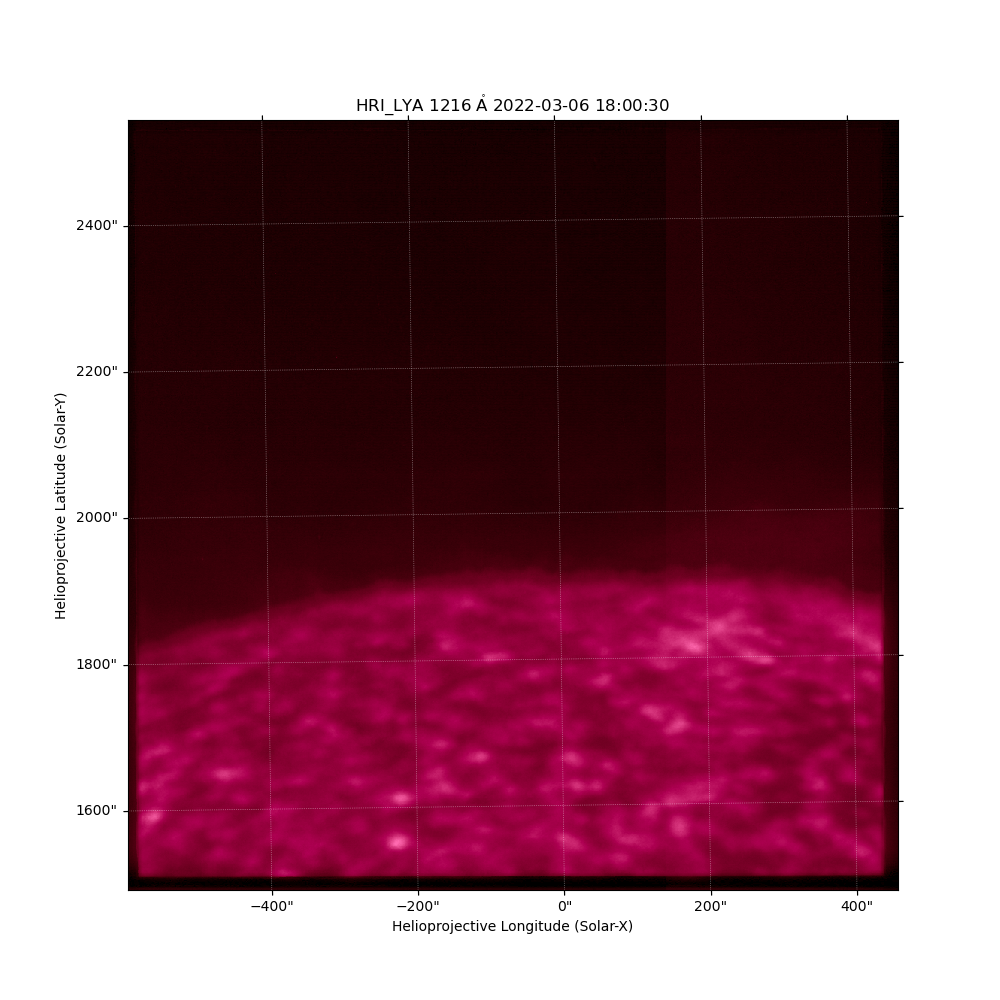

In [47]:
sequence_1 = sunpy.map.Map(files_1, sequence=True)

for each_map in sequence_1:
    each_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=300, stretch=SqrtStretch())
plt.figure()
anim_1 = sequence_1.plot()

plt.show()

In [48]:
plt.close()

Unfortunately, the resolution of the HRI LYA images is somewhat limited. Even outside of the remote sensing window - with the further reduced resolution of the instrument - we always bin the images 2 x 2 to reduce the required telemetry without further sacrificing on image quality.

The HRI LYA instrument has another problem in that the image intensifier causes an after image to show, meaning that each image we see is the result of whatever the telescope should see right now and what it saw before the exposure started. This is causing some additional blurring, and this also makes it difficult to analyze fast brightness changes. 

HRI LYA images are typically recorded with the low-gain channel only. 

### HRI EUV
We will repeat the exercise for retrieving and displaying HRI EUV data.

In [49]:
instrument = a.Instrument('EUI')
time = a.Time('2022-03-27 21:24:00', '2022-03-27 21:50:00')
level = a.Level(2)
product = a.soar.Product('EUI-HRIEUV174-IMAGE')

result_2 = Fido.search(instrument & time & level & product)
print(result_2)

Results from 1 Provider:

26 Results from the SOARClient:

Instrument     Data product    Level        Start time               End time        Filesize                              SOOP Name                              Detector Wavelength
                                                                                      Mbyte                                                                                          
---------- ------------------- ----- ----------------------- ----------------------- -------- ------------------------------------------------------------------- -------- ----------
       EUI eui-hrieuv174-image    L2 2022-03-27 21:24:10.251 2022-03-27 21:24:13.051    6.189 L_FULL_HRES_HCAD_Coronal-Dynamics;L_FULL_HRES_HCAD_Coronal-Dynamics  HRI_EUV      174.0
       EUI eui-hrieuv174-image    L2 2022-03-27 21:25:10.251 2022-03-27 21:25:13.051    6.391 L_FULL_HRES_HCAD_Coronal-Dynamics;L_FULL_HRES_HCAD_Coronal-Dynamics  HRI_EUV      174.0
       EUI eui-hrieuv174-image 

In [50]:
files_2 = Fido.fetch(result_2, path="./")

Files Downloaded:   0%|          | 0/26 [00:00<?, ?file/s]

And again we have a look at the resulting sequence

In [51]:
sequence_2 = sunpy.map.Map(files_2, sequence=True)
for each_map in sequence_2:
    each_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=2000, stretch=SqrtStretch())
plt.figure()
anim_2 = sequence_2.plot()

plt.show()

The HRI EUV instrument performs very well and the resolution is almost limited by the size of the pixels (~0.5 arc seconds). The HRI EUV detector is typically operated in combined gain mode, which means that on-board low-gain and high-gain pixels are combined into a resulting image with a high dynamic range.

In [52]:
plt.close()

### Correct for Solar Differential Rotation

In [53]:


# Choose a reference map (middle of the sequence is a good choice)
ref_map = sequence_2[len(sequence_2) // 2]

# Reproject every map to the WCS of the reference map,
# while treating coordinates as points on the rotating solar surface
with propagate_with_solar_surface():
    hrieuv_derot = sunpy.map.Map(
        [m.reproject_to(ref_map.wcs) for m in sequence_2],
        sequence=True
    )


#### Plot the derotated sequence animation

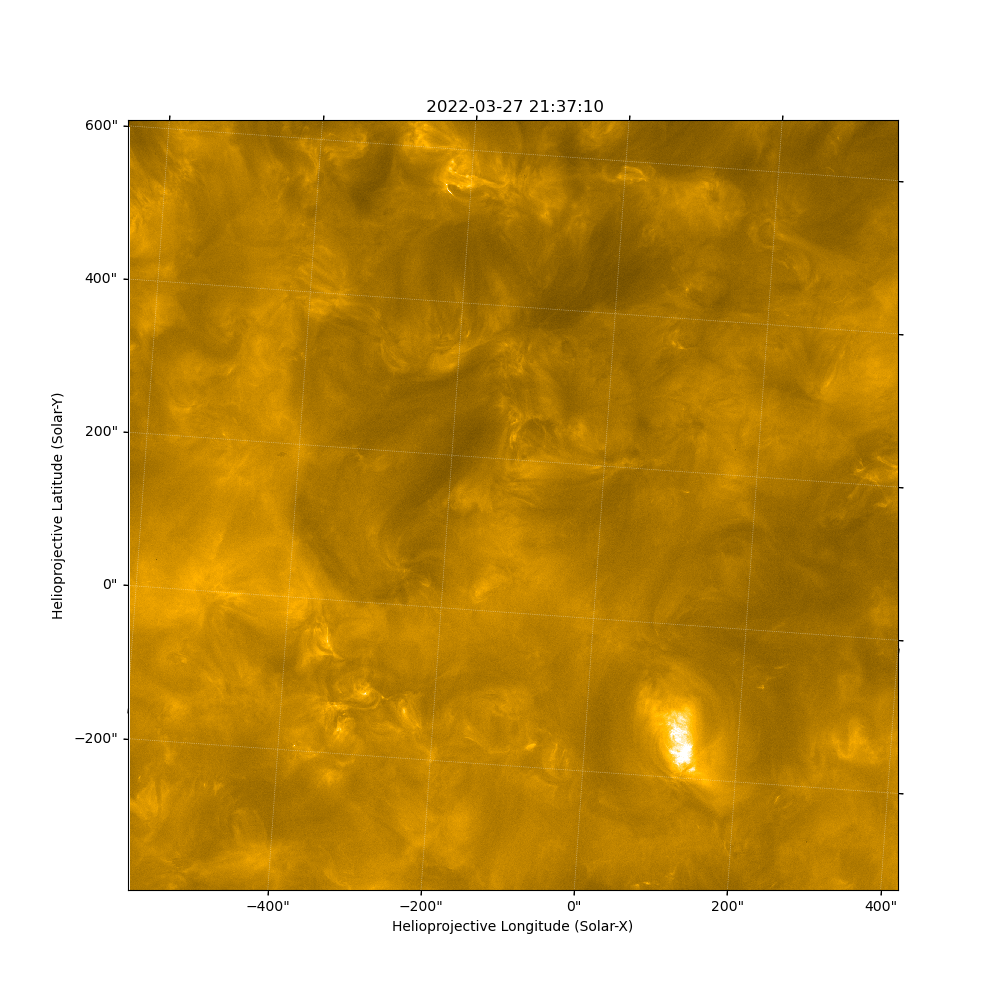

In [54]:


# Apply normalization to each map
for m in hrieuv_derot:
    m.plot_settings['norm'] = ImageNormalize(
        vmin=0, vmax=2000, stretch=SqrtStretch()
    )

# SunPy creates and manages the figure itself
plt.figure()
anim_3 = hrieuv_derot.plot(interval=200)
plt.show()


In [55]:
plt.close()

In [56]:
plt.close()

### FSI 
Just like the HRI EUV data, the low and high gain channels of the FSI instrument are combined onboard, which means that the images are also calibrated onboard. The process works well, but again there are some limitations. We will now try to retrieve and display some FSI data where the filter wheel was in one of the two 174 positions.

In [57]:
time = a.Time('2022-03-27 21:24:00', '2022-03-27 21:34:00')
level = a.Level(2)
product = a.soar.Product('EUI-FSI174-IMAGE')
result_3 = Fido.search(instrument & time & level & product)

In [58]:
result_3

<sunpy.net.fido_factory.UnifiedResponse object at 0x30fea5480>
Results from 1 Provider:

1 Results from the SOARClient:

Instrument   Data product   Level        Start time               End time        Filesize                              SOOP Name                              Detector Wavelength
                                                                                   Mbyte                                                                                          
---------- ---------------- ----- ----------------------- ----------------------- -------- ------------------------------------------------------------------- -------- ----------
       EUI eui-fsi174-image    L2 2022-03-27 21:28:45.245 2022-03-27 21:28:55.245     5.76 L_FULL_HRES_HCAD_Coronal-Dynamics;L_FULL_HRES_HCAD_Coronal-Dynamics      FSI      174.0

In [59]:
files_3 = Fido.fetch(result_3,path='./')

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

We open the files as a SunPy map, and tell this map to normalize the image by heavily stretching the data between 0 and the 99.9 percentile file:

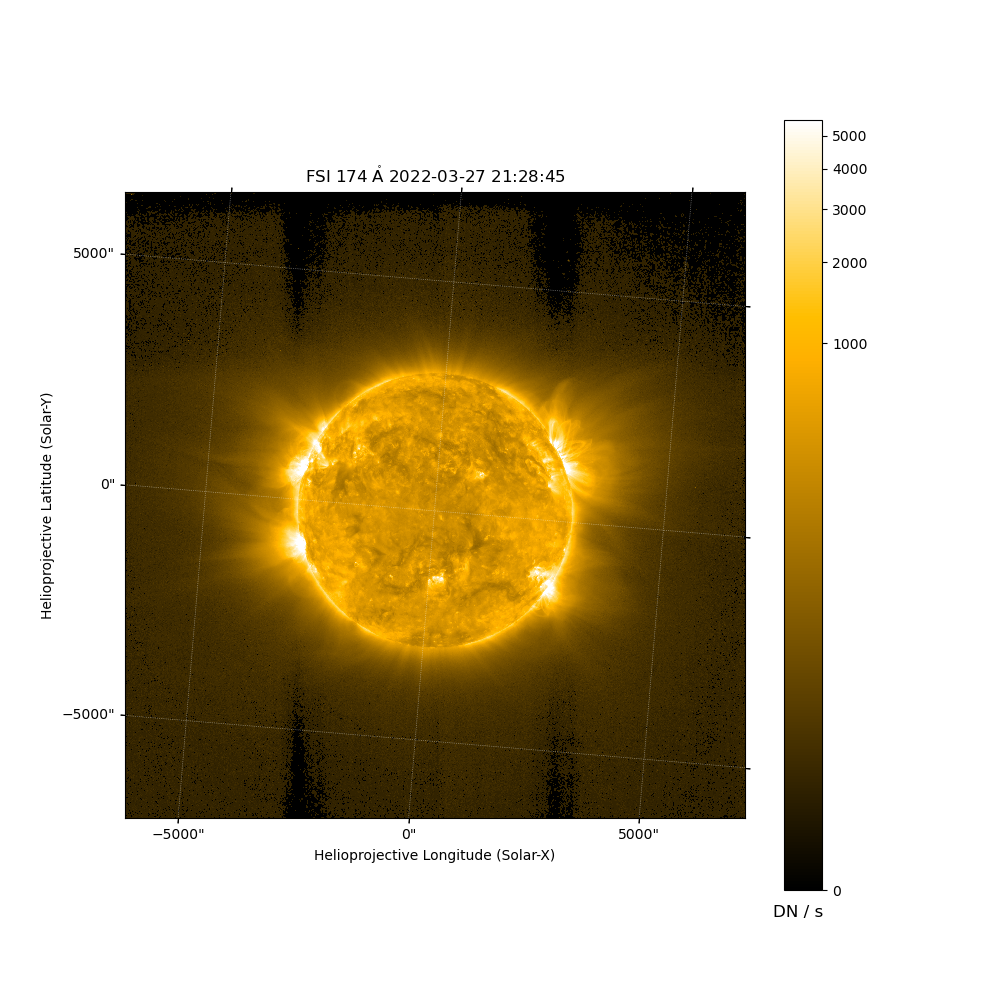

In [60]:
fsieuv_map = sunpy.map.Map(files_3)
fsieuv_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=np.percentile(fsieuv_map.data,99.9), stretch=PowerStretch(0.2))
plt.figure()
fsieuv_map.peek()


In [61]:
plt.close()

We can see some typical dark bands that are detector artifacts caused by bright features visible on the solar limb. Another thing that stands out in FSI images, particularly when we are close to the Sun, is that the bottom ~ 75% of the image is a little bit (~ 1 DN) brighter than the top of the image. This could be caused by a small light leak.

Now we will have a look at some interesting FSI 304 data. Here, the filter wheel was in one of the two 304 positions.

First we again search for data through Fido.

In [62]:
time = a.Time('2022-02-15 22:00:00', '2022-02-15 22:34:00')
level = a.Level(2)
product = a.soar.Product('EUI-FSI304-IMAGE')
result_4 = Fido.search(instrument & time & level & product)

In [63]:
result_4

<sunpy.net.fido_factory.UnifiedResponse object at 0x30ff03f00>
Results from 1 Provider:

14 Results from the SOARClient:

Instrument   Data product   Level        Start time               End time        Filesize SOOP Name Detector Wavelength
                                                                                   Mbyte                                
---------- ---------------- ----- ----------------------- ----------------------- -------- --------- -------- ----------
       EUI eui-fsi304-image    L2 2022-02-15 22:00:15.218 2022-02-15 22:00:25.218    2.854      none      FSI      304.0
       EUI eui-fsi304-image    L2 2022-02-15 22:02:15.219 2022-02-15 22:02:25.219    2.618      none      FSI      304.0
       EUI eui-fsi304-image    L2 2022-02-15 22:04:15.219 2022-02-15 22:04:25.219    2.676      none      FSI      304.0
       EUI eui-fsi304-image    L2 2022-02-15 22:06:15.219 2022-02-15 22:06:25.219    2.796      none      FSI      304.0
       EUI eui-fsi304-image    L2 2022-02-15 22:10:15.220 2022-02-15 22:10:25.220    2.771      none      FSI      304.0
       EUI eui-fsi304-image    L2 2022-02-15 22:12:15.219 2022-02-15 22:12:25.219    2.903      none      FSI      304.0
       EUI eui-fsi304-image    L2 2022-02-15 22:14:15.220 2022-02-15 22:14:25.220    3.018      none      FSI      304.0
       EUI eui-fsi304-image    L2 2022-02-15 22:16:15.220 2022-02-15 22:16:25.220    3.018      none      FSI      304.0
       EUI eui-fsi304-image    L2 2022-02-15 22:20:15.220 2022-02-15 22:20:25.220     2.86      none      FSI      304.0
       EUI eui-fsi304-image    L2 2022-02-15 22:22:15.221 2022-02-15 22:22:25.221    2.915      none      FSI      304.0
       EUI eui-fsi304-image    L2 2022-02-15 22:24:15.221 2022-02-15 22:24:25.221    2.952      none      FSI      304.0
       EUI eui-fsi304-image    L2 2022-02-15 22:26:15.221 2022-02-15 22:26:25.221    2.926      none      FSI      304.0
       EUI eui-fsi304-image    L2 2022-02-15 22:30:15.222 2022-02-15 22:30:25.222    2.987      none      FSI      304.0
       EUI eui-fsi304-image    L2 2022-02-15 22:32:15.222 2022-02-15 22:32:25.222     2.54      none      FSI      304.0

In [64]:
files_4 = Fido.fetch(result_4,path='./')

Files Downloaded:   0%|          | 0/14 [00:00<?, ?file/s]

We ended up with 14 images that we are going to display. This time we again stretch the data (a lot!) to have a look at the faintest details in the image. We will also create a little animation of the result.

In [65]:
sequence_4 = sunpy.map.Map(files_4, sequence=True)
for each_map in sequence_4:
    each_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=np.percentile(sequence_4.data,99.99), stretch=PowerStretch(0.2))
    
plt.figure()    
anim_4 = sequence_4.plot(interval=500)
plt.show()

In [66]:
plt.close()

If you look closely, you can see a blocky pattern in the background of the image. This is caused by the flat-field correction not being applied correctly onboard. The brightness level of that artifact is only about 1 DN, which means it's only visible when heavily stretching the image, but 1 DN is enough to make it difficult to spot faint eruptions further out from the Sun. 